In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score # Optional, for another evaluation metric


In [4]:
np.random.seed(42)
num_customers = 200

In [5]:
data_dict = {
    'Annual_Spending_USD': np.concatenate([
        np.random.normal(500, 100, 50),   # Low Spenders
        np.random.normal(2000, 300, 50),  # Medium Spenders
        np.random.normal(5000, 800, 50),  # High Spenders
        np.random.normal(1200, 200, 50)   # Another medium group
    ]),
    'Customer_Age': np.concatenate([
        np.random.normal(25, 5, 50),      # Young
        np.random.normal(40, 7, 50),      # Middle-aged
        np.random.normal(55, 8, 50),      # Older
        np.random.normal(30, 6, 50)       # Younger, mixed
    ])
}
data = pd.DataFrame(data_dict)

In [6]:
# min 18 years old and min 100 USD spending
data['Annual_Spending_USD'] = data['Annual_Spending_USD'].apply(lambda x: max(x, 100))
data['Customer_Age'] = data['Customer_Age'].apply(lambda x: max(x, 18))


In [7]:
data.head()

,Annual_Spending_USD,Customer_Age
0,549.671415,26.788937
1,486.173570,27.803923
2,564.768854,30.415256
3,652.302986,30.269010
4,476.584663,18.111653


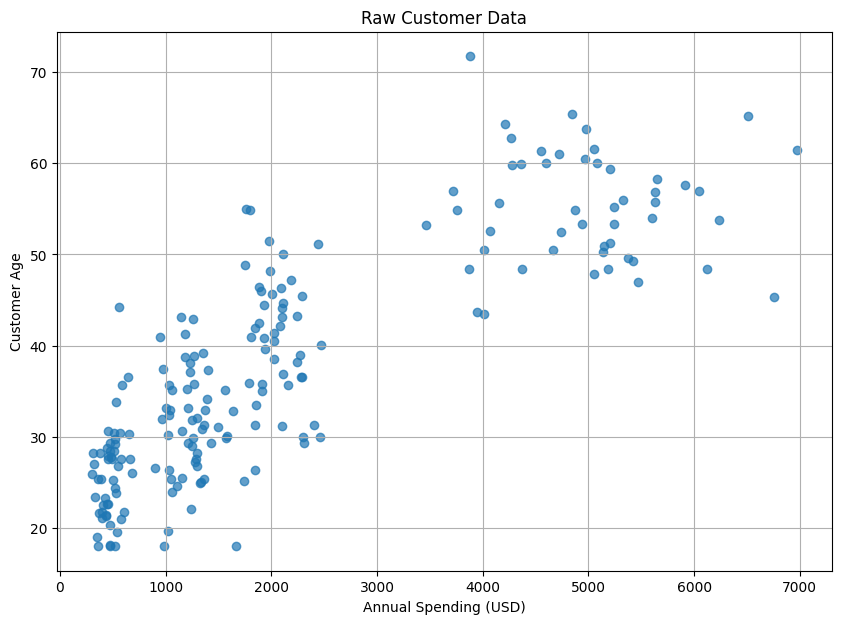

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(data['Annual_Spending_USD'], data['Customer_Age'], alpha=0.7)
plt.xlabel("Annual Spending (USD)")
plt.ylabel("Customer Age")
plt.title("Raw Customer Data")
plt.grid(True)
plt.show()

In [9]:
# This is CRUCIAL for K-Means as it's distance-based.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


In [19]:
import random
def initialize_centroids(data, k):
    # Randomly select k data points as initial centroids
    indices = random.sample(range(data.shape[0]), k)
    centroids = data[indices]
    return centroids

k = 5
initial_centroids = initialize_centroids(scaled_data, k) # Initialize from scaled data
print("\nInitial Centroids (Scaled):\n", initial_centroids)



Initial Centroids (Scaled):
 [[-0.17661178 -0.354507  ]
 [-0.8872586  -1.27897721]
 [ 0.07616339 -0.63098753]
 [-0.45220647 -0.3984594 ]
 [-0.52985746 -0.07467668]]


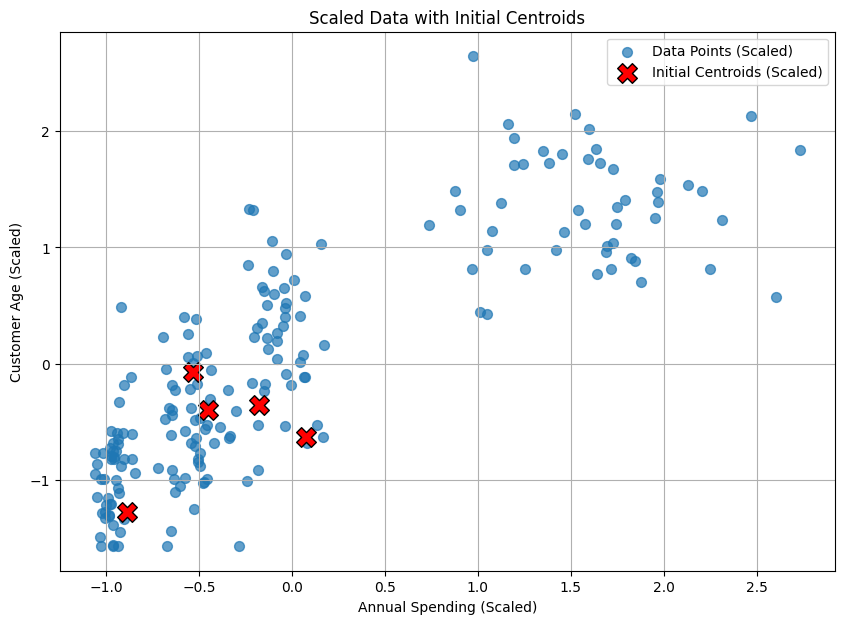

In [20]:
# Initial Centroids
plt.figure(figsize=(10, 7))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s=50, alpha=0.7, label='Data Points (Scaled)')
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], s=200, marker='X', color='red', label='Initial Centroids (Scaled)', edgecolors='black')
plt.title("Scaled Data with Initial Centroids")
plt.xlabel("Annual Spending (Scaled)")
plt.ylabel("Customer Age (Scaled)")
plt.grid(True)
plt.legend()
plt.show()

### Assign Points to Nearest Centroids

In [21]:
def assign_to_clusters(data, centroids):
    # Calculate Euclidean distance from each point to each centroid
    # np.linalg.norm computes Euclidean norm (distance) along axis=2
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    # np.argmin finds the index of the minimum distance for each data point
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments

In [22]:
def update_centroids(data, assignments, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        # Find all data points assigned to cluster i
        points_in_cluster = data[assignments == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
        else:
            # Handle empty clusters: re-initialize random point or keep old centroid.
            pass
    return new_centroids

In [23]:
# Test 1st train
centroids = initialize_centroids(scaled_data, k)
print("centroids : ",centroids)
assignments = assign_to_clusters(scaled_data, centroids)
print("assignments : ",assignments)

updated_centroids = update_centroids(scaled_data, assignments, k)
print("updated_centroids : ",updated_centroids)

centroids :  [[-0.57493792 -0.98763265]
 [-0.49568692 -0.76606652]
 [-0.03887489  0.47801963]
 [-0.97928545 -0.72471795]
 [ 2.72973807  1.8429562 ]]
assignments :  [3 3 3 3 0 0 3 3 3 2 3 3 3 3 3 3 0 0 0 3 3 0 3 0 0 3 3 0 0 3 0 3 3 0 3 3 0
 3 0 3 0 3 3 3 0 3 0 0 3 3 1 2 2 2 1 2 2 1 2 2 1 2 0 1 2 1 2 1 2 2 2 1 2 2
 1 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 4 4 4 4 4 4 4 4 2
 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 2 4 2 4 4 4 2 4 4 2 4 4 2 4 4 4 2 2
 4 4 1 2 1 1 1 0 1 1 1 0 1 2 1 1 1 1 1 1 1 0 1 1 2 1 2 0 1 1 2 0 0 0 0 1 0
 1 1 2 1 0 0 1 0 2 1 1 0 2 1 3]
updated_centroids :  [[-0.78320458 -1.25930814]
 [-0.39693856 -0.50214949]
 [ 0.06259586  0.49949613]
 [-0.94677296 -0.74140266]
 [ 1.74688189  1.45228439]]


In [24]:
def kmeans(data, k, max_iterations=100, tolerance=1e-4):
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iterations):
        old_centroids = centroids.copy()
        
        # Step 1: Assign points to nearest centroids
        assignments = assign_to_clusters(data, centroids)
        
        # Step 2: Update centroids
        centroids = update_centroids(data, assignments, k)
        
        # Check for convergence: if centroids don't move much
        if np.linalg.norm(centroids - old_centroids) < tolerance:
            print(f"K-Means converged after {i+1} iterations.")
            break
    else:
        print(f"K-Means reached max iterations ({max_iterations}) without converging.")
            
    return centroids, assignments

# Run the K-Means algorithm on the SCALED data
final_centroids_scaled, final_assignments = kmeans(scaled_data, k)

print("\nFinal Centroids (Scaled):\n", final_centroids_scaled)


K-Means converged after 11 iterations.

Final Centroids (Scaled):
 [[-0.15489513  0.50029336]
 [-0.79530967 -0.82734772]
 [-0.37340417 -0.34308802]
 [-0.90154376 -1.35828908]
 [ 1.59204002  1.35234214]]


In [25]:
final_assignments

array([1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3,
       1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 3, 1, 1, 1,
       3, 3, 3, 3, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 3, 2, 0, 2,
       0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1,
       2, 2, 0, 1, 1, 1, 3, 1, 1, 2, 2, 0, 2, 1, 1, 2, 3, 0, 2, 1, 3, 2,
       1, 2])

In [26]:
final_centroids_original_scale = scaler.inverse_transform(final_centroids_scaled)
final_centroids_original_scale

array([[1894.4628376 ,   44.401997  ],
       [ 767.51609291,   27.48730034],
       [1509.94930365,   33.65696925],
       [ 580.57442762,   20.7228877 ],
       [4968.56994666,   55.25745094]])

Text(0.5, 1.0, 'K-Means Clustering Result')

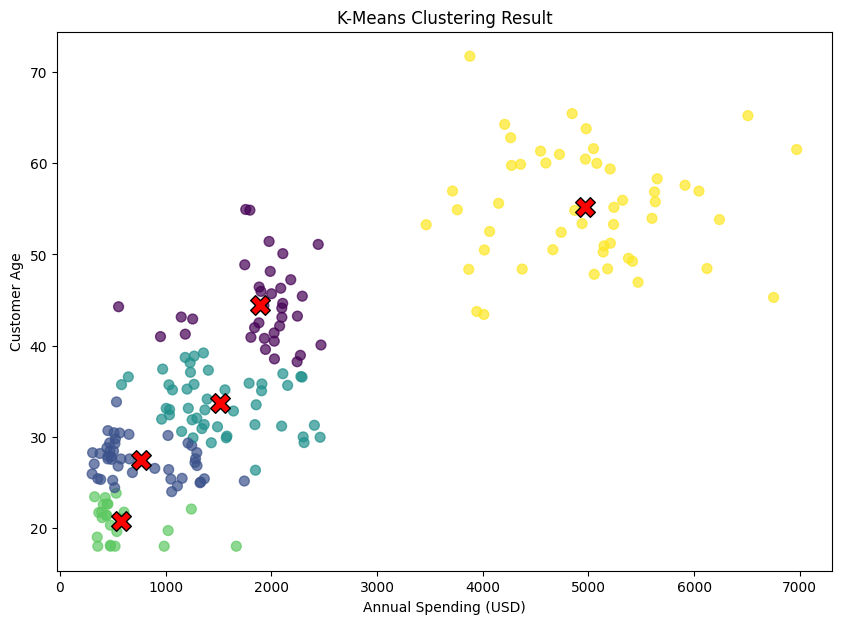

In [27]:
# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(data['Annual_Spending_USD'], data['Customer_Age'], c=final_assignments, s=50, alpha=0.7, cmap='viridis')
plt.scatter(final_centroids_original_scale[:, 0], final_centroids_original_scale[:, 1], s=200, marker='X', color='red', edgecolors='black')
plt.xlabel("Annual Spending (USD)")
plt.ylabel("Customer Age")
plt.title("K-Means Clustering Result")